Copyright (C) 2023 Glencoe Software, Inc. All Rights Reserved.

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.

### Unsupervised Clustering for Whole Slide Image with omero2pandas

This notebook demonstrates how to retrieve analytical data stored as an [OMERO.table](https://docs.openmicroscopy.org/omero-blitz/5.5.8/slice2html/omero/grid/Table.html) from the [OMERO.server](https://www.glencoesoftware.com/products/omeroplus/) using [omero2pandas](https://github.com/glencoesoftware/omero2pandas) and build unsupervised clustering model to profile the cells.

The example below uses the output of the image processing performed using [OMERO-Segmentation Connector for WSI](https://www.glencoesoftware.com/solutions/digital-pathology/) which utilizes [StarDist](https://github.com/stardist/stardist) as a segmenter. Derived features (parameters describing cells' shape, intensity and neighborhood) are then used to build a clustering model using [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html). Finally the cluster ids are assigned to each object and saved to [OMERO.tables](https://docs.openmicroscopy.org/omero-blitz/5.5.8/slice2html/omero/grid/Table.html) using [omero2pandas](https://github.com/glencoesoftware/omero2pandas). The stored data can be visualized remotely with [PathViewer](https://www.glencoesoftware.com/products/pathviewer/) and [Pageant](https://www.glencoesoftware.com/products/pageant/).

##### Workflow
 * Load OMERO.table to Pandas DataFrame using omero2pandas
 * Pre-process the data (replace missing values, normalize, etc.)
 * Remove strongly correlated features using Spearman correlation
 * Run dimensionality reduction using UMAP
 * Build an unsupervised clustering model and classify the cells
 * Visualize the results using Datashader, Bokeh, and HoloViews
 * Save the result to OMERO.tables for visualization with [PathViewer](https://www.glencoesoftware.com/products/pathviewer/) and [Pageant](https://www.glencoesoftware.com/products/pageant/), or other downstream workflows

In [1]:
import logging

numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)

In [2]:
%%capture

from umap import UMAP

In [3]:
%%capture

import os
import pandas as pd
import omero2pandas
import numpy as np
from scipy.stats import spearmanr
from sklearn.cluster import Birch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from umap import UMAP
from sklearn.decomposition import PCA
import holoviews as hv
import holoviews.operation.datashader as hd
from bokeh.models import HoverTool
from holoviews import opts
import datashader as ds
from matplotlib.colors import ListedColormap
from bokeh.palettes import Viridis256
from bokeh.plotting import show

hv.extension('bokeh')

In [4]:
import skimage.exposure
import shapely
import shapely.wkt
import math
import shapely.affinity
import matplotlib.pyplot as plt

#### Define variables and OMERO IDs that will be used for the next steps

In [5]:
# Define the image and table IDs
# Image ID will be used to link the uploaded table to the image
IMAGE_ID = 1912
# Table ID
TABLE_FILE_ID = 14510
# Analysis ID - distinct name for the local files and the table
# Can also use uuid lib to generate a random ID
ANALYSIS_ID = "95a5420c-9732-4a49-961c-cf43264a7b50"

# Where to store the downloaded table?
table_path = f"./objects_{ANALYSIS_ID}.csv"
# The name will be used as OMERO.table name
output_table_name = f"{ANALYSIS_ID}_unsupervised_clustering"
# Store outputs locally
output_table_path = f"{output_table_name}.csv"

#### Load the table from OMERO and save it locally for future us

If [omero-user-token](https://github.com/glencoesoftware/omero-user-token) is installed and valid [omero2pandas](https://github.com/glencoesoftware/omero2pandas) will use it automatically for the OMERO.server connection otherwise it will ask for the connection details.

##### Without omero-user-token

In [5]:
# Initialize Connector
connector = omero2pandas.connect_to_omero(
    server="where.is.your.omero.server",
    username="what.is.your.username",
    password="what.is.your.password")

Connected to apps.dev.omero-plus.io


In [6]:
# Load the data
omero2pandas.download_table(
    table_path, file_id=TABLE_FILE_ID, chunk_size=10000,
    omero_connector=connector)

##### With omero-user-token

In [14]:
# Load the data, auth and connection is handled via omero-user-token
omero2pandas.download_table(
    table_path, file_id=TABLE_FILE_ID, chunk_size=10000)

Connected to apps.dev.omero-plus.io


#### Load the table from disk

In [6]:
# Skip columns that are not needed for clustering
columns_to_skip = [
    "prob", "polygon", "centroid", "bbox_min_x", "bbox_min_y", "bbox_max_x", "bbox_max_y",
    "prob_thresh", "nms_thresh", "polygon_centroid_x", "polygon_centroid_y", "polygon_bbox",
    "polygon_min_rot_rect", "raster_centroid_y", "raster_centroid_x", "tile_index",
    "nearest_object", "roi"
]

In [6]:
# From dist, needs to be switched to omero2pandas
df = pd.read_csv(
    table_path,
    usecols=lambda column: column not in columns_to_skip
)

#### Preprocess the data (replace missing values, normalize, etc.)

In [8]:
df.fillna(df.mean(), inplace=True)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
print(f"Shape raw: {df_scaled.shape}")

Shape raw: (500000, 307)


#### Remove strongly correlated features using Spearman correlation

In [10]:
corr_matrix, _ = spearmanr(df_scaled)
corr_threshold = 0.9

corr_matrix = np.abs(corr_matrix)
np.fill_diagonal(corr_matrix, 0)
cols_to_remove = []
for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[1]):
        if corr_matrix[i, j] > corr_threshold:
            cols_to_remove.append(j)

# Remove correlated columns
print(f"Found {len(set(cols_to_remove))} to remove")
df_scaled = df_scaled[:, list(set(range(df_scaled.shape[1])) - set(cols_to_remove))]
print(f"Shape spearmaned: {df_scaled.shape}")

Found 0 to remove
Shape spearmaned: (500000, 82)


#### Dimensionality reduction using UMAP

In [11]:
%%capture

# pca = PCA(n_components=2)
# df_reduced = pca.fit_transform(df_scaled)

reducer = UMAP(n_components=2, low_memory=True)
df_reduced = reducer.fit_transform(df_scaled)

#### Clustering

#### Find optimum number of clusters

In [6]:
# Define the range of clusters to try
n_clusters_range = range(2, 19)
ch_scores = []
db_scores = []

for n_clusters in n_clusters_range:
    print(n_clusters)
    birch = Birch(n_clusters=n_clusters, branching_factor=50, threshold=0.5)
    clusters = birch.fit_predict(df_reduced)
    ch_score = calinski_harabasz_score(df_reduced, clusters)
    ch_scores.append(ch_score)
    db_score = davies_bouldin_score(df_reduced, clusters)
    db_scores.append(db_score)

# Find the optimal number of clusters using the elbow method
optimal_clusters_ch = n_clusters_range[np.argmax(ch_scores)]
optimal_clusters_db = n_clusters_range[np.argmin(db_scores)]
print(f"CH: {ch_scores}")
print(f"DB: {db_scores}")
print(f"Optimal CH: {optimal_clusters_ch}, Optimal DB: {optimal_clusters_db}")

n_clusters = min([optimal_clusters_ch, optimal_clusters_db])

# Calculate clusters

birch = Birch(n_clusters=n_clusters, branching_factor=50, threshold=0.5)
clusters = birch.fit_predict(df_reduced)
print(f'Number of clusters identified: {len(np.unique(clusters))}')

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
CH: [8548.830968561631, 162211.8353836989, 148992.0861990337, 112811.98844055133, 94847.49221796962, 87051.16909739483, 74766.08259322333, 221475.5876233015, 197432.91026139422, 177856.44290296585, 183383.389271722, 168758.47089394837, 156408.5393031664, 145593.9235561664, 159068.59359019483, 149182.27681486125, 140533.80766651587]
DB: [0.49892720615123287, 0.9217888985503627, 0.8411822051366689, 0.6707548957074821, 0.6397796808260114, 0.6537660028222555, 0.6895218943334774, 0.6652803098474886, 0.6546078678670433, 0.5686382541344497, 0.602495089992296, 0.6646700112893077, 0.6763088591226946, 0.692985699833145, 0.7258272236991318, 0.6675323651614432, 0.6706590058235556]
Optimal CH: 9, Optimal DB: 2
Number of clusters identified: 2


#### Or use a fixed number

In [12]:
n_clusters = 5
birch = Birch(n_clusters=5, branching_factor=50, threshold=0.5)
clusters = birch.fit_predict(df_reduced)
print(f'Number of clusters identified: {len(np.unique(clusters))}')

Number of clusters identified: 5


#### Visualize the results using Datashader, Bokeh, and HoloViews

In [9]:
colors = ['#FFA500', '#FF00FF', '#00FFFF', '#FFFF00', '#FF0000']
cmap = ListedColormap(colors)

In [13]:
df_reduced_labels = pd.DataFrame(df_reduced, columns=['UMAP1', 'UMAP2'])
df_reduced_labels['Cluster'] = clusters
df_reduced_labels.head()

,UMAP1,UMAP2,Cluster
0,12.559985,-0.156121,1
1,10.789196,0.583535,1
2,10.038660,0.362964,1
3,10.465014,0.335364,1
4,9.910857,0.645336,1


In [14]:
colors = ['#FFA500', '#FF00FF', '#00FFFF', '#FFFF00', '#FF0000']
cmap = ListedColormap(colors)

df_reduced_labels = pd.DataFrame(df_reduced, columns=['UMAP1', 'UMAP2'])
df_reduced_labels['Cluster'] = clusters
points = hv.Points(df_reduced_labels, kdims=['UMAP1', 'UMAP2'], vdims=['Cluster'])

In [15]:
datashaded = hd.datashade(points, aggregator=ds.count_cat('Cluster'), color_key=cmap)
hover = HoverTool(tooltips=[('Cluster', '@Cluster')])
opts.defaults(opts.RGB(tools=[hover]))
plot = datashaded.opts(width=800, height=800)
hv.render(plot)

Figure(id='1006', ...)

#### Show example cell for each label

In [17]:
# Merge the original dataset with the new DataFrame on index
df_original = pd.read_csv(table_path, usecols=['object'] + columns_to_skip)
df_labeled = df_original.merge(df_reduced_labels, left_index=True, right_index=True)

In [18]:
df_labeled.head()

,object,prob,polygon,centroid,bbox_min_x,bbox_min_y,bbox_max_x,bbox_max_y,prob_thresh,nms_thresh,...,polygon_bbox,polygon_min_rot_rect,raster_centroid_y,raster_centroid_x,tile_index,nearest_object,roi,UMAP1,UMAP2,Cluster
0,1,0.483748,"POLYGON ((746.704345703125 10160, 746.33465576...",POINT (742.8420755280428 10160.00173679036),739.195618,10156.444336,746.704346,10163.665039,0.479071,0.3,...,"POLYGON ((739.1956176757812 10156.4443359375, ...","POLYGON ((746.9015607102662 10163.37895624251,...",10159.550000,742.250000,11,-1,2038,12.559985,-0.156121,1
1,2,0.912714,"POLYGON ((901.2435302734375 27912, 900.5768432...",POINT (889.8568234644157 27912.035999986587),878.947937,27898.771484,901.243530,27925.275391,0.479071,0.3,...,"POLYGON ((878.9479370117188 27898.771484375, 9...","POLYGON ((876.4823036524576 27922.94341846238,...",27911.561555,889.360691,30,7,2038,10.789196,0.583535,1
2,3,0.911478,"POLYGON ((620.9896850585938 28112, 620.2854614...",POINT (610.0222623486634 28111.0383113105),598.603149,28099.779297,620.989685,28122.238281,0.479071,0.3,...,"POLYGON ((598.6031494140625 28099.779296875, 6...","POLYGON ((598.7960617217437 28122.4452065584, ...",28110.545455,609.540404,30,-1,2038,10.038660,0.362964,1
3,4,0.903430,"POLYGON ((939.1497802734375 27838, 938.3896484...",POINT (926.5268208001696 27838.0755411473),914.584717,27826.935547,939.149780,27849.691406,0.479071,0.3,...,"POLYGON ((914.584716796875 27826.935546875, 93...",POLYGON ((940.6016025786357 27847.447551637953...,27671.543578,12.018349,30,10,2038,10.465014,0.335364,1
4,5,0.891712,"POLYGON ((891.408203125 27892, 886.57360839843...",POINT (875.5334526718246 27890.43671011221),857.480347,27878.464844,895.363708,27903.857422,0.479071,0.3,...,"POLYGON ((857.4803466796875 27878.46484375, 89...","POLYGON ((899.093139403205 27896.741274306383,...",27671.986068,18.086687,30,15,2038,9.910857,0.645336,1


In [35]:
to_grab = []
for label in range(5):
    poly = shapely.wkt.loads(df_labeled[df_labeled["Cluster"] == label]["polygon"].iloc[5])
    x1, y1, x2, y2 = poly.buffer(10).bounds
    x1 = math.floor(x1)
    y1 = math.floor(y1)
    x2 = math.ceil(x2)
    y2 = math.ceil(y2)
    to_grab.append((label, poly, x1, y1, x2 - x1, y2 - y1))

In [43]:
ims = []

red_channel = 12
green_channel = 7
blue_channel = 0

colors = (red_channel, green_channel, blue_channel)

In [44]:
max_h = max_w = 0
for _, _, _, _, w, h in to_grab:
    max_h = max(max_h, h)
    max_w = max(max_w, w)
    
max_h = (int(math.ceil(max_h / 10.0)) * 10) + 1
max_w = (int(math.ceil(max_w / 10.0)) * 10) + 1
moved_polys = []

ims = []
with omero2pandas.connect_to_omero(
        server="where.is.your.omero.server",
        username="what.is.your.username",
        password="what.is.your.password") as connector:
    conn = connector.get_gateway()
    conn.SERVICE_OPTS.setOmeroGroup('-1')
    print("Gateway open")
    img = conn.getObject("Image", 1912)
    pixel_fetcher = img.getPrimaryPixels()
    for cluster_id, poly, x, y, _, _ in to_grab:
        moved_poly = shapely.affinity.translate(poly, xoff=-x, yoff=-y)
        moved_polys.append(moved_poly)
        want = [(0, c, 0, (x, y, max_w, max_h)) for c in colors]
        data = pixel_fetcher.getTiles(want)
        ims.append(list(data))
        print("Done ", cluster_id)
print("Image data downloaded")

Connected to apps.dev.omero-plus.io
Gateway open
Done  0
Done  1
Done  2
Done  3
Done  4
Image data downloaded


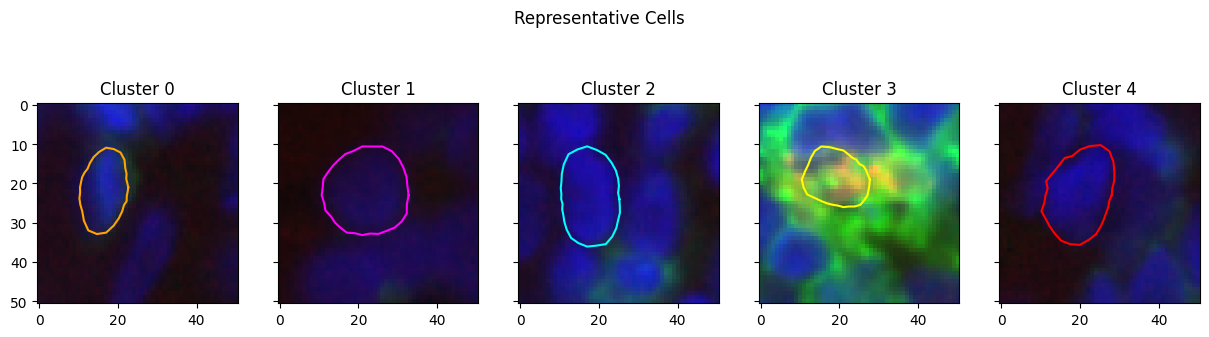

In [48]:
# Calculate display bounds
blue_max = df['raster_01_Hoechst_intensity_max'].mean() + (df['raster_01_Hoechst_intensity_max'].std() * 2)
red_max = df['raster_13_E-Cadherin_Argo730_intensity_max'].mean() + (df['raster_13_E-Cadherin_Argo730_intensity_max'].std() * 2)
green_max = df['raster_08_CD4_Argo572_intensity_max'].mean() + (df['raster_08_CD4_Argo572_intensity_max'].std() * 2)

fig, axs = plt.subplots(1, 5, sharex=True, sharey=True)
fig.set_figheight(4)
fig.set_figwidth(15)
fig.suptitle("Representative Cells")
px = 0
py = 0

for i, img_data in enumerate(ims):
    red, green, blue = img_data.copy()
    poly = moved_polys[i]
    red = skimage.exposure.rescale_intensity(red, in_range=(0, red_max), out_range=(0, 1))
    green = skimage.exposure.rescale_intensity(green, in_range=(0, green_max), out_range=(0, 1))
    blue = skimage.exposure.rescale_intensity(blue, in_range=(0, blue_max), out_range=(0, 1))
    preview = np.dstack((red, green, blue))
    
    axs[px].imshow(preview)
    axs[px].plot(*poly.exterior.xy, color=cmap(i))
    axs[px].set_title(f"Cluster {i}")

    px += 1

#### Save the result

In [35]:
# Upload the table to OMERO
ann_id = omero2pandas.upload_table(
    df_labeled, output_table_name, IMAGE_ID, "Image", chunk_size=10000)

Connected to apps.dev.omero-plus.io


Uploading table to OMERO: 100%|██████████| 1201949/1201949 rows, 53:44 
